In [1]:
import pymc3 as pm
import theano.tensor as tt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

%matplotlib inline

/Users/demetri/miniconda3/envs/datascience/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!python run_data_gen.py 
df = pd.read_csv('data/test.csv', index_col = 0)
df.index = df.index.rename('subject')
df = df.reset_index()

df['subject'] = df.subject.astype('category').cat.codes
df.head()

/Users/demetri/miniconda3/envs/datascience/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


,subject,t,Cl,ka,ke,x_0,x_1,x_2,x_3,delay,y,y_obs
0,0,0.500000,1.849918,0.483634,0.355964,-1.352203,0.746388,1.0,1.0,0.177496,0.131071,0.161973
1,0,2.142857,1.849918,0.483634,0.355964,-1.352203,0.746388,1.0,1.0,0.177496,0.401794,0.421559
2,0,3.785714,1.849918,0.483634,0.355964,-1.352203,0.746388,1.0,1.0,0.177496,0.372417,0.418829
3,0,5.428571,1.849918,0.483634,0.355964,-1.352203,0.746388,1.0,1.0,0.177496,0.274621,0.359351
4,0,7.071429,1.849918,0.483634,0.355964,-1.352203,0.746388,1.0,1.0,0.177496,0.183341,0.229397


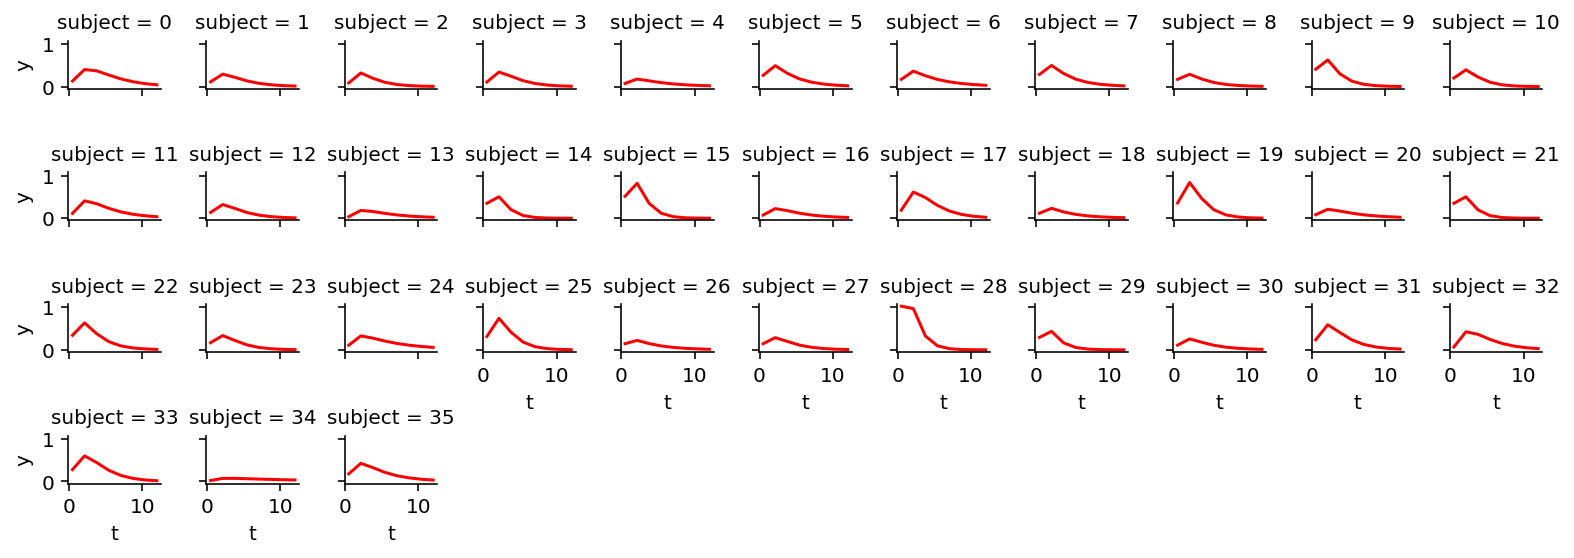

In [13]:


g = sns.FacetGrid(data = df, col='subject', col_wrap=11, sharey=True, size = 1)

g.map_dataframe(sns.lineplot,'t', 'y', color='red')



In [14]:
idx = df.subject.values
t = df.t.values
yobs = df.y_obs.values
X = df.drop_duplicates('subject').loc[:, df.columns[df.columns.str.contains('x')]]

n,p = X.shape

with pm.Model() as pkmodel:
    
    baseline_cl = pm.Bound(pm.Normal, lower=0)('baseline_cl', mu = tt.log(3), sd=1)
    baseline_ke = pm.Normal('baseline_ke', mu = 0, sd=1)
    alpha = pm.Beta('alpha',1,1)
    baseline_ka = pm.Deterministic('baseline_ka', tt.log(1.0/alpha) + baseline_ke)
    
    baseline = tt.stack([baseline_cl, baseline_ka, baseline_ke])
    sigma = pm.Gamma('sigma',.5,1)
    S = pm.HalfCauchy('S',1, shape=3)
    z = pm.Normal('z', mu = 0, sd = 1, shape= (n,3))
    
    beta = pm.Normal('beta', mu=0, sd=0.1, shape = (p,3))
#     params = pm.Deterministic('params', tt.exp(baseline + tt.dot(X,beta) + tt.dot(z, tt.diag(S))))

    params = pm.Deterministic('params', tt.exp(baseline + tt.dot(z, tt.diag(S))))

    CL = params[tuple(idx), 0]
    KA = params[tuple(idx), 1]
    KE = params[tuple(idx), 2]
    
    delay_mu = pm.Beta('mu', 1,1)
    delay_kappa = pm.Pareto('kappa', m=5, alpha=1)
    delay = pm.Beta('delay', alpha = delay_mu*delay_kappa, beta=(1-delay_mu)*delay_kappa, shape=n)
    dt = t-0.5*delay[idx]
    
    c = (5/CL)*(KE*KA)/(KE-KA)*(tt.exp(-KA*dt) - tt.exp(-KE*dt))
    concentration = pm.Deterministic('conc', c)
    
    Y = pm.Lognormal('Yobs', mu = tt.log(concentration), sd = sigma, observed = yobs)
    
    prior = pm.sample_prior_predictive(samples=1)
    trace = pm.sample(random_seed = 0)



/Users/demetri/miniconda3/envs/datascience/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/demetri/miniconda3/envs/datascience/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/Users/demetri/miniconda3/envs/datascience/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

In [15]:
trace['diverging'].any()


True

In [16]:
d = az.from_pymc3(trace)

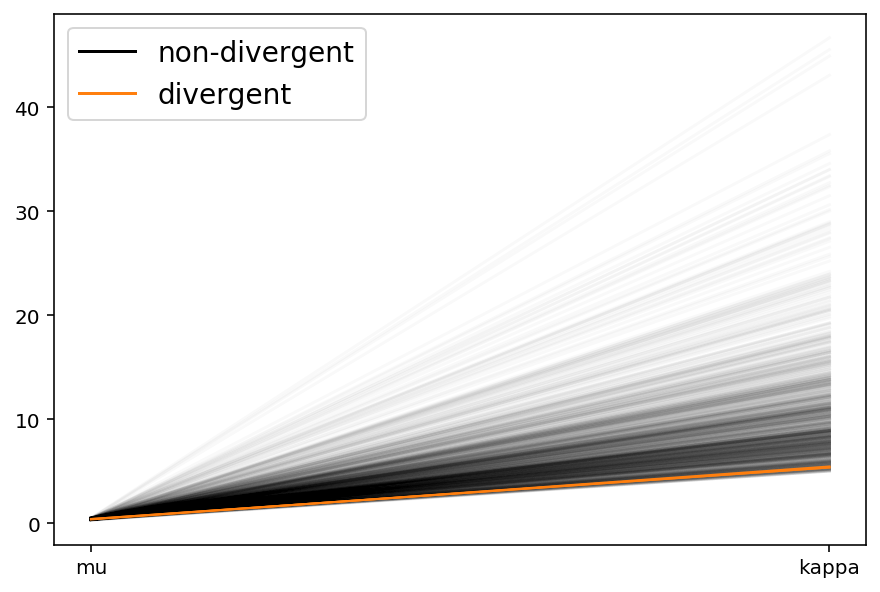

In [17]:
az.plot_parallel(data = d, 
                 var_names=['mu','kappa'])

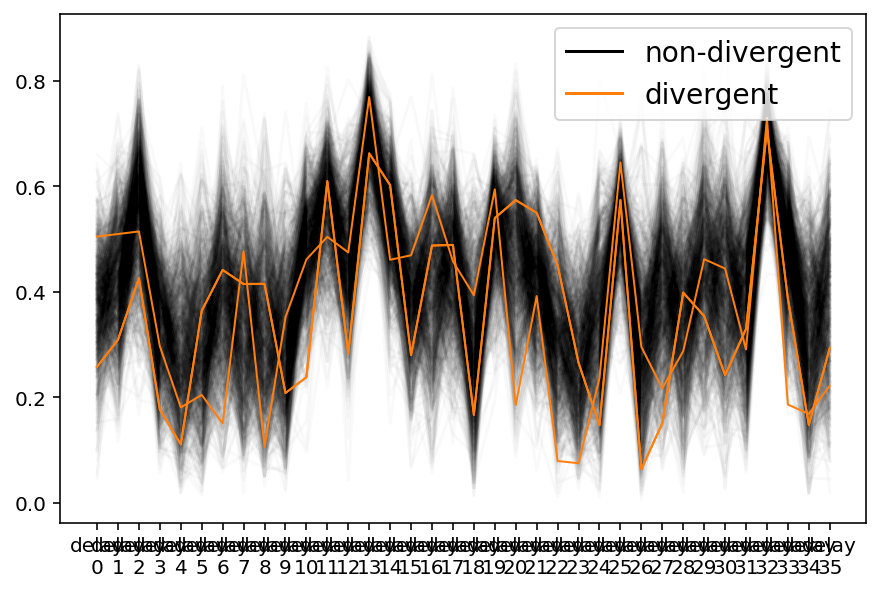

In [18]:
az.plot_parallel(data = d, 
                 var_names=['delay'])

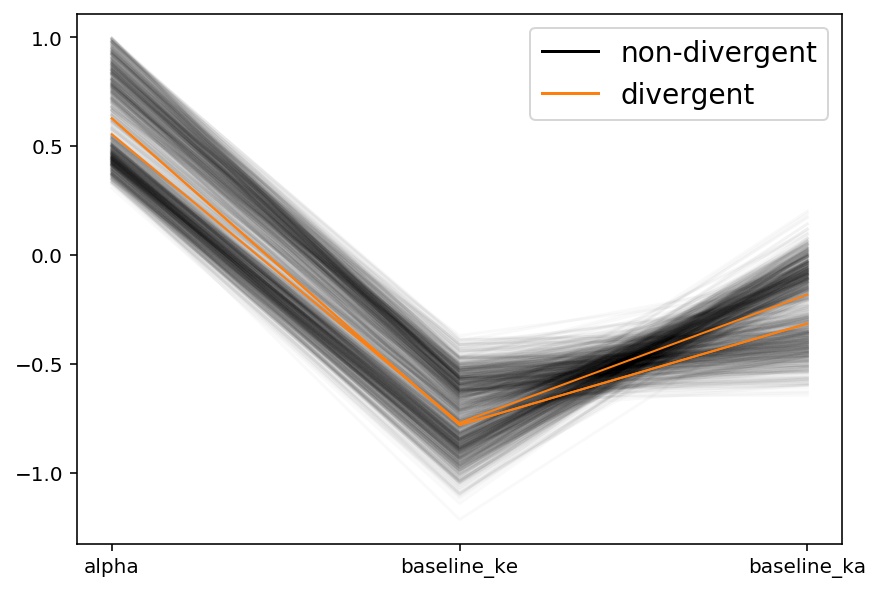

In [22]:
az.plot_parallel(d, var_names=['alpha', 'baseline_ke','baseline_ka'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3decba58>,
      dtype=object)

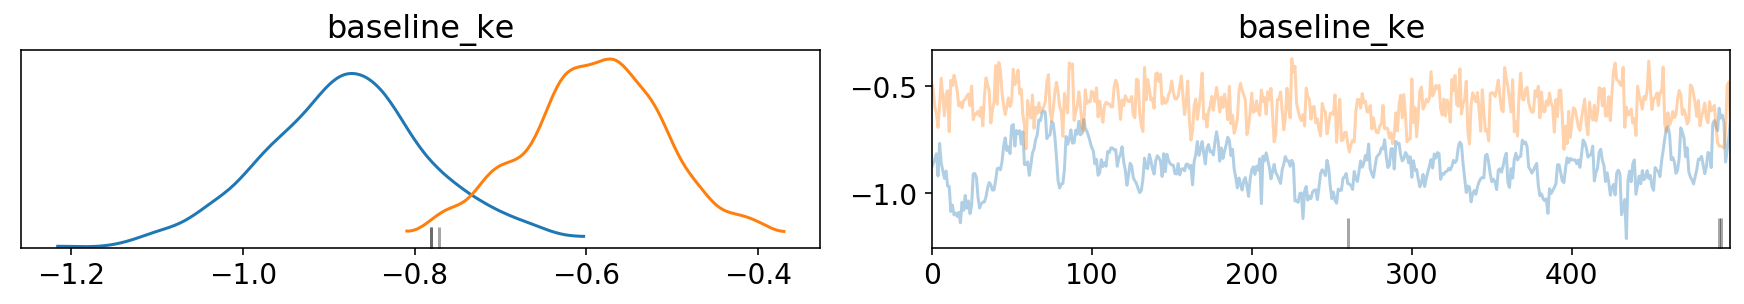

In [24]:
az.plot_trace(d, var_names=['baseline_ke'])